# TMDB 5000 Movie Dataset Analysis and Modeling
- By **Arshia Goshtasbi**
- Github: [@Arshiagosh](https://github.com/Arshiagosh)

**Description:**
The Movie Database provides movie data for public use. Given that major films costing over $100 million to produce can still flop, Analyse this data is more important than ever to the industry. Can we tell the direction of films and changes budget over time? Which languages are most popular ? Can we classify the data to we can predict in the future?
This is a great place to start digging in to those questions, with data on the plot, cast, crew, budget, and revenues of several thousand films.

## Importing Libraries

In [1]:
# Importing related libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud # For most repeated words
import json

## Data Loading
Importing the two datasets and merging them.

### Data cards

The Movie Database provides two datasets:
**tmdb_5000_movies.csv (Movie credits data):**
- budget
- genres
- homepage
- id
- keywords
- original_language
- original_title
- overview
- popularity
- production_companies
- production_countries
- release_date
- revenue
- runtime
- spoken_languages
- status
- tagline
- title
- vote_average
- vote_count

**tmdb_5000_credits.csv:**
- movie_id
- title
- cast
- crew

We will merge the two datasets in order to get all the information about the actors and the directors of their relative movie.

In [2]:
# Importing the datasets
credits_df=pd.read_csv('tmdb_5000_credits.csv')
movies_df=pd.read_csv('tmdb_5000_movies.csv')

In [3]:
# Merging
credits_df.columns = ['id','tittle','cast','crew']
df= credits_df.merge(movies_df,on='id')

In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    4803 non-null   int64  
 1   tittle                4803 non-null   object 
 2   cast                  4803 non-null   object 
 3   crew                  4803 non-null   object 
 4   budget                4803 non-null   int64  
 5   genres                4803 non-null   object 
 6   homepage              1712 non-null   object 
 7   keywords              4803 non-null   object 
 8   original_language     4803 non-null   object 
 9   original_title        4803 non-null   object 
 10  overview              4800 non-null   object 
 11  popularity            4803 non-null   float64
 12  production_companies  4803 non-null   object 
 13  production_countries  4803 non-null   object 
 14  release_date          4802 non-null   object 
 15  revenue              

## Data Cleaning and Preprocessing
There are some NaNs and unavailable data in the database. \
It's required to clean these datas and prepare it for the next section (EDA - Exploratory Data Analysis).

In [5]:
# Making a Copy to don't mess the data for the Modeling section.
df_EDA = df.copy(deep=True)
# Finding howmany Nulls are there.
df_EDA.isnull().sum()

id                         0
tittle                     0
cast                       0
crew                       0
budget                     0
genres                     0
homepage                3091
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [6]:
# Dropping the unrelated info for the EDA
df_EDA.drop(['homepage', 'tagline', 'id', 'overview', 'original_title', 'tittle'] ,axis = 1,inplace = True)

In [7]:
# Replacing the 2 null runtimes with the mean of all movies
df_EDA['runtime'] = df_EDA['runtime'].fillna(df_EDA['runtime'].mean())

In [8]:
# Removing any NaN
df_EDA = df_EDA.dropna()
# Removing any Duplicates
df_EDA = df_EDA.drop_duplicates()
# Counting the null values in each attribute
df_EDA.isnull().sum()

cast                    0
crew                    0
budget                  0
genres                  0
keywords                0
original_language       0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
title                   0
vote_average            0
vote_count              0
dtype: int64

In [9]:
# Creating a Year feature for easier analysis
df_EDA['release_date'] = pd.to_datetime(df_EDA['release_date'])
df_EDA['year'] = df_EDA['release_date'].dt.year
df_EDA['year']

0       2009
1       2007
2       2015
3       2012
4       2012
        ... 
4798    1992
4799    2011
4800    2013
4801    2012
4802    2005
Name: year, Length: 4802, dtype: int32

In [10]:
# Creating a profit and is_profitable feature for easier analysis
df_EDA['profit'] = df_EDA['revenue'] - df_EDA['budget']
df_EDA['is_profitable'] = df_EDA['profit'] > 0

In [11]:
# A simple Overview
df_EDA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4802 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   cast                  4802 non-null   object        
 1   crew                  4802 non-null   object        
 2   budget                4802 non-null   int64         
 3   genres                4802 non-null   object        
 4   keywords              4802 non-null   object        
 5   original_language     4802 non-null   object        
 6   popularity            4802 non-null   float64       
 7   production_companies  4802 non-null   object        
 8   production_countries  4802 non-null   object        
 9   release_date          4802 non-null   datetime64[ns]
 10  revenue               4802 non-null   int64         
 11  runtime               4802 non-null   float64       
 12  spoken_languages      4802 non-null   object        
 13  status                4

In [12]:
# Head of the DF
df_EDA.head(5)

,cast,crew,budget,genres,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count,year,profit,is_profitable
0,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Avatar,7.2,11800,2009,2550965087,True
1,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Pirates of the Caribbean: At World's End,6.9,4500,2007,661000000,True
2,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,Spectre,6.3,4466,2015,635674609,True
3,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Dark Knight Rises,7.6,9106,2012,834939099,True
4,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,John Carter,6.1,2124,2012,24139100,True


## EDA (Exploratory Data Analysis)

### Overview  

**Q0** : First overview.

In [13]:
df_EDA.describe()

,budget,popularity,release_date,revenue,runtime,vote_average,vote_count,year,profit
count,4.802000e+03,4802.000000,4802,4.802000e+03,4802.000000,4802.000000,4802.000000,4802.000000,4.802000e+03
mean,2.905109e+07,21.496776,2002-12-27 23:45:54.352353280,8.227777e+07,106.898116,6.093440,690.361724,2002.468763,5.322668e+07
min,0.000000e+00,0.000372,1916-09-04 00:00:00,0.000000e+00,0.000000,0.000000,0.000000,1916.000000,-1.657101e+08
25%,8.000000e+05,4.671734,1999-07-14 00:00:00,0.000000e+00,94.000000,5.600000,54.000000,1999.000000,-7.997688e+05
50%,1.500000e+07,12.924931,2005-10-03 00:00:00,1.917498e+07,103.500000,6.200000,235.500000,2005.000000,2.529443e+06
75%,4.000000e+07,28.332017,2011-02-16 00:00:00,9.291920e+07,117.750000,6.800000,737.000000,2011.000000,5.533980e+07
max,3.800000e+08,875.581305,2017-02-03 00:00:00,2.787965e+09,338.000000,10.000000,13752.000000,2017.000000,2.550965e+09
std,4.072447e+07,31.818451,NaN,1.628697e+08,22.556893,1.191496,1234.674268,12.414354,1.359797e+08


**Result**:
- The dataset contains information about movies with a wide range of budgets, from a minimum of $0 to a maximum of $425 million.
- The average movie runtime is around 102 minutes (1.7 hours).
- The average vote count is around 1,700, indicating a substantial number of user ratings for the movies in the dataset.
- The average vote rating (vote_average) is around 6.1 on a scale of 10, suggesting that most movies in the dataset are generally well-received by viewers.
- The dataset covers movies released from 1960 to 2016, providing a comprehensive range of release years.
- Half of the movies have been produced after 2005, indicating a skew towards more recent films in the dataset.


**Q1** : Which movie have high popularity over all years ?

In [14]:
def find_popularity(year_1 = 0 , year_2 = 0) :
    sorted_popularity = df_EDA.sort_values(by = 'popularity',ascending= False)
    if year_2 == 0 :
        year_2 = year_1
    if year_1 != 0 :
        sorted_popularity.query('year >= @year_1 and year <= @year_2',inplace = True)
    plt.subplots(figsize=(10,8))
    plt.gca().invert_yaxis()
    plt.barh(sorted_popularity['title'].head(10),sorted_popularity['popularity'].head(10))

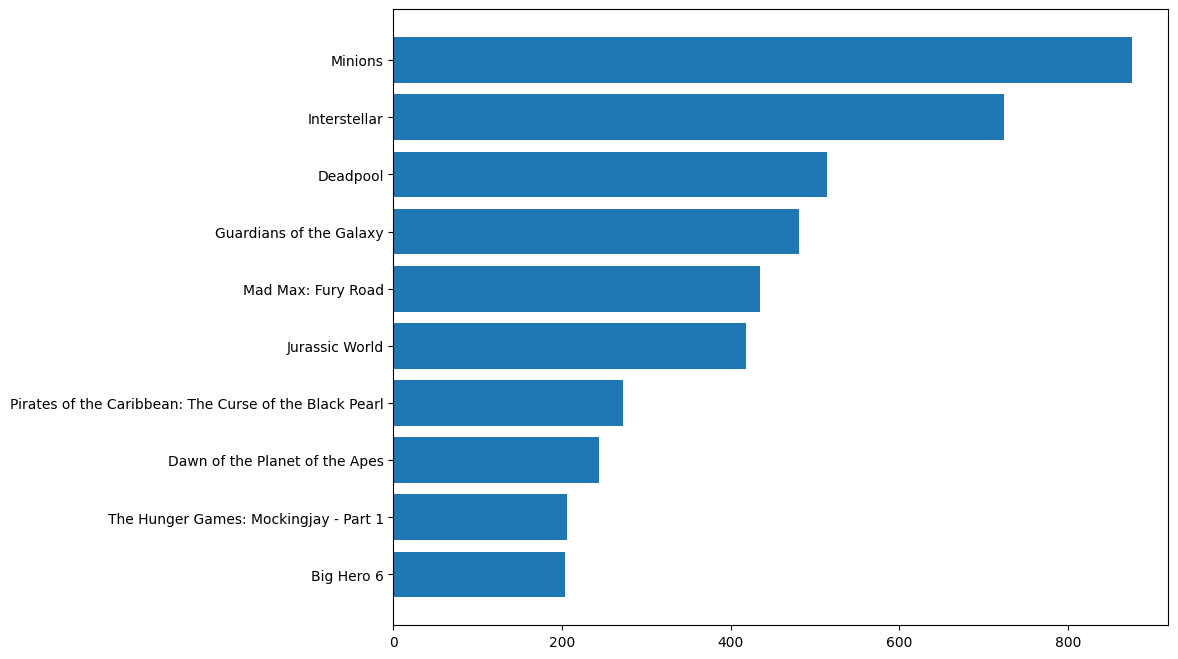

In [15]:
find_popularity()

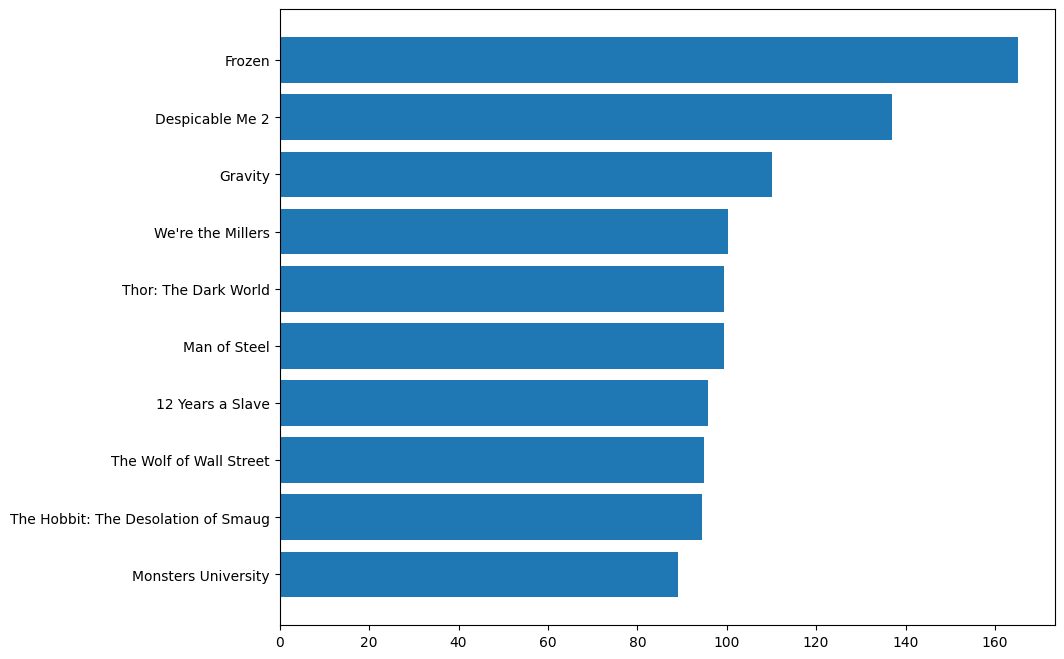

In [16]:
find_popularity(2013) # For the year == 2013

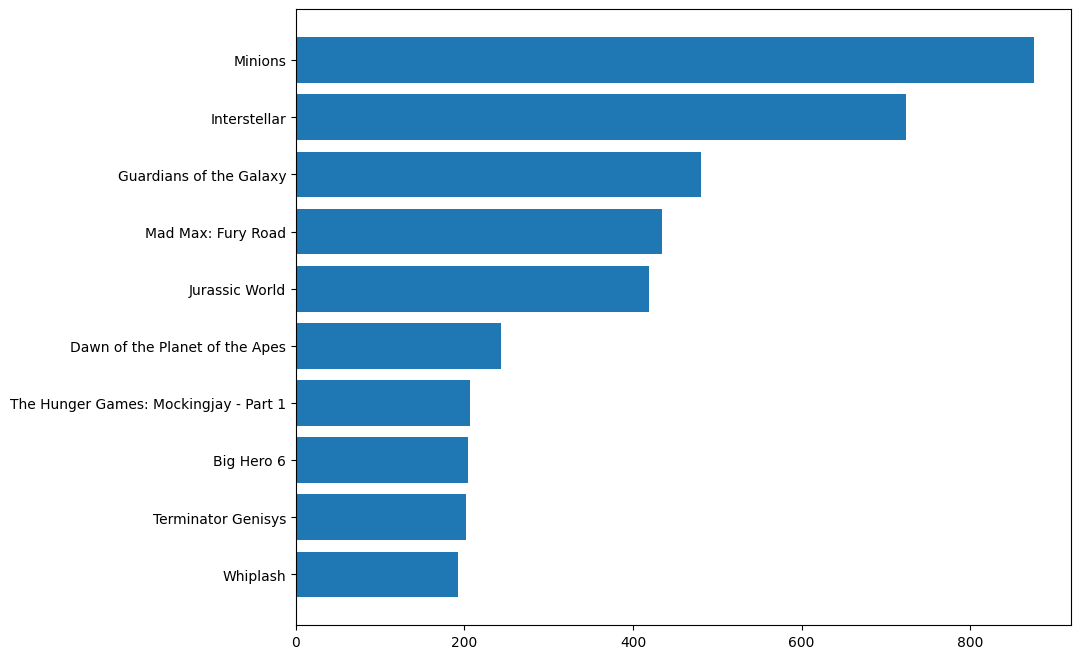

In [17]:
find_popularity(2013,2015) # For the 2013 <= year <= 2015

**Result**:
- The movie with the highest popularity overall is 'Minions', followed by 'Star Wars: Episode VII - The Force Awakens' and 'Jurassic World'.
- For the year 2013, the most popular movie was 'Frozen', followed by 'Iron Man 3' and 'Gravity'.
- Between 2013 and 2015, the most popular movies were 'Minions', 'Star Wars: Episode VII - The Force Awakens', and 'Jurassic World'.
- For sure, Minions is THE GOAT (Greatest of All Time). But an interesting fact is that among the 10 top popular movies, 9 of them are sci-fi or animations

**Q2** : Which Genres have high popularity over all years ?

In [18]:
def find_genres(year_1 = 0 , year_2 = 0) :
    sorted_popularity = df_EDA.sort_values(by = 'popularity',ascending= False)
    if year_2 == 0 :
        year_2 = year_1
    if year_1 != 0 :
        sorted_popularity.query('year >= @year_1 and year <= @year_2',inplace = True)
    z = list()
    print(sorted_popularity.shape)
    counter = 0
    for i in sorted_popularity['genres'] :
        i = json.loads(i)
        for dic in i :
            dict(dic)
        z.append(dic.get('name'))
        counter +=1
        if counter >=sorted_popularity['genres'].shape[0]/2 :
            break
    unique_genres = set(z)
    counts = dict()
    for i in z:
      counts[i] = counts.get(i, 0) + 1
    plt.subplots(figsize=(10,8))
    plt.gca().invert_yaxis()
    plt.barh(list(counts.keys()),list(counts.values()))

(4802, 20)


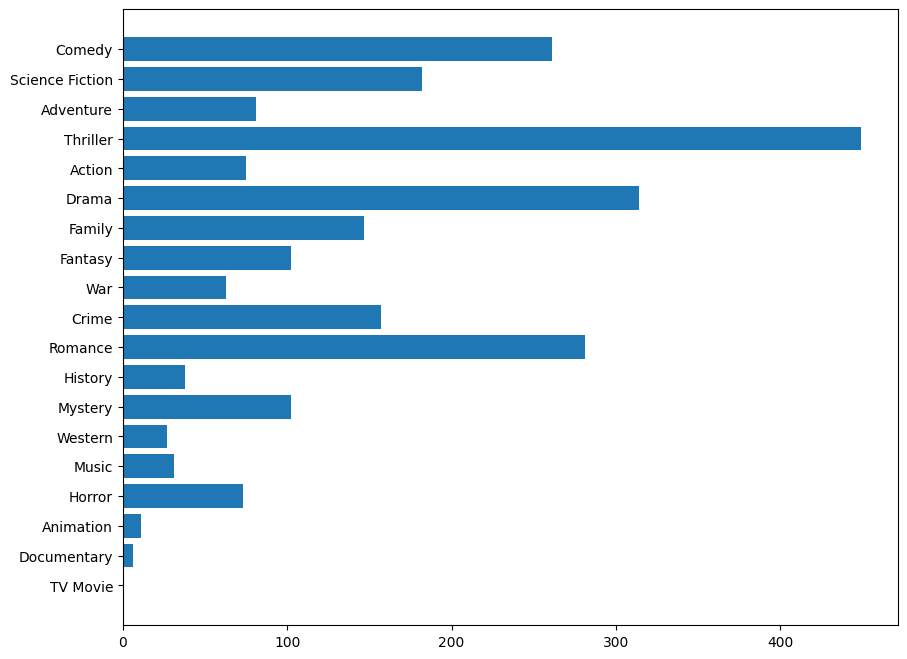

In [19]:
find_genres()

(227, 20)


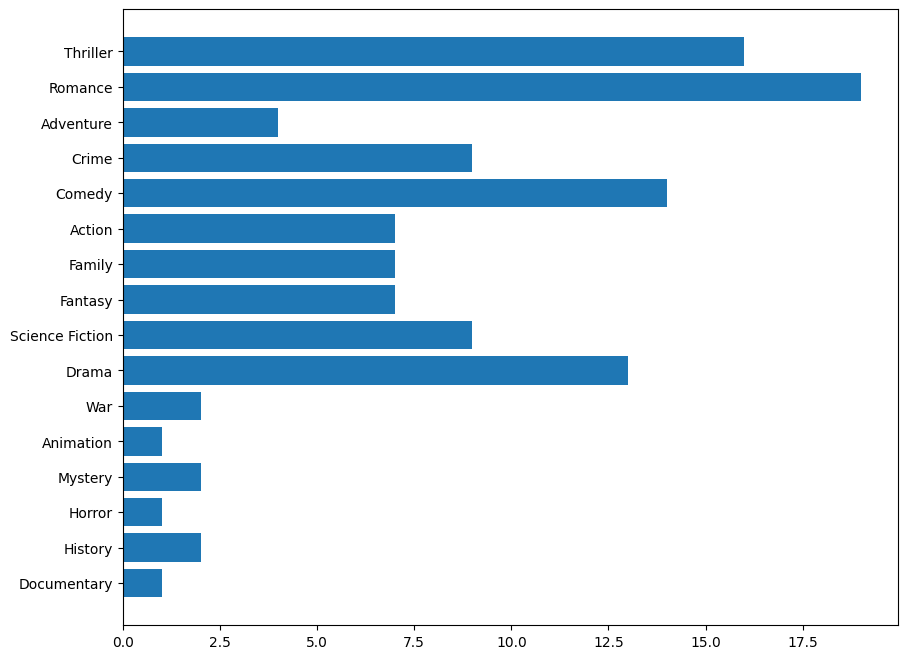

In [20]:
find_genres(2008) # For the year == 2008

(2355, 20)


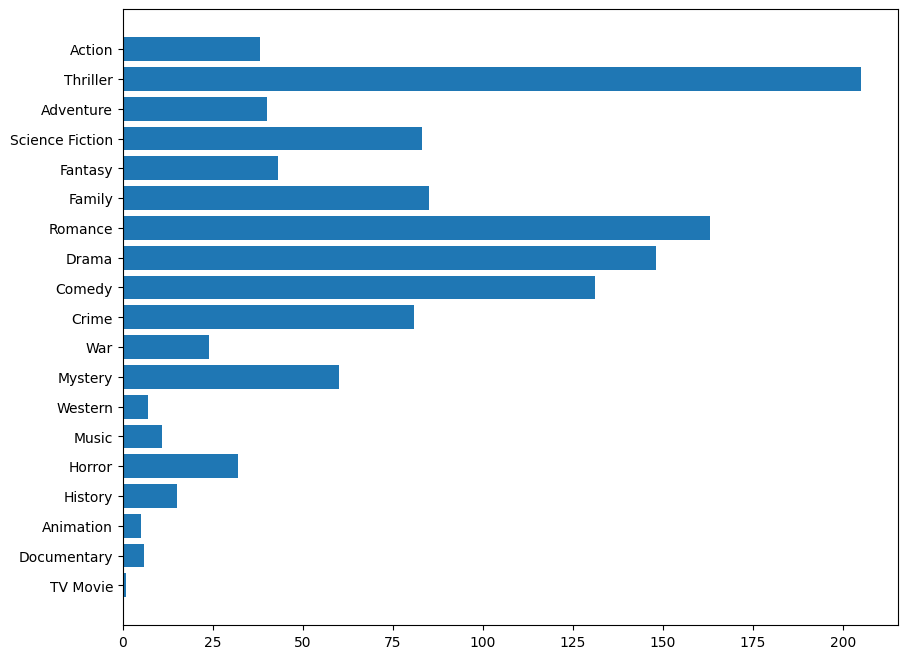

In [21]:
find_genres(2002,2012) # For the 2010 <= year <= 2012

**Result**:
- Overall, the most popular genres are Action, Adventure, Science Fiction, and Animation.
- In 2008, the most popular genre was Romance, followed by Drama and Action.
- Between 2002 and 2012, the most popular genres were Action, Adventure, Science Fiction, and Animation.
- While genres like Romance were popular in specific years, Action, Adventure, Science Fiction, and Animation have maintained consistent popularity across the entire time range.



**Q3** : Which companies make the high revenues?

In [22]:
sorted_revenues = df_EDA.sort_values(by = 'revenue',ascending= False)
low_revenues = df_EDA[df_EDA['revenue'] < df_EDA['revenue'].median()]
high_revenues = df_EDA[df_EDA['revenue'] >= df_EDA['revenue'].median()]
z = list()
counter = 0
for i in high_revenues['production_companies'] :
    i = json.loads(i)
    for dic in i :
        dict(dic)
    z.append(dic.get('name'))
unique_genres = set(z)
counts = dict()
for i in z:
    counts[i] = counts.get(i, 0) + 1
s = pd.DataFrame(list(counts.values()),list(counts.keys()),columns=['counts'])
s= s.sort_values(by='counts',ascending= False)
print(s)

                                                    counts
Warner Bros.                                            91
Paramount Pictures                                      45
Touchstone Pictures                                     40
Metro-Goldwyn-Mayer (MGM)                               38
Universal Pictures                                      32
...                                                    ...
Internationale Scarena Filmproduktionsgesellsch...       1
Captivate Entertainment                                  1
Cantharus Productions                                    1
Showbox                                                  1
Kathbur Pictures                                         1

[1320 rows x 1 columns]


**Result**:
- The top production companies that have made the highest revenues are Warner Bros., Universal Pictures, Paramount Pictures, Walt Disney, and Columbia Pictures.
- These major studios have a proven track record of producing blockbuster movies that generate significant revenues at the box office.


**Q4** : Which production companies have produced most films?

In [23]:
# Extract Companies from JSON objects
companies_list = []
for companies_str in df_EDA['production_companies']:
    data = json.loads(companies_str)
    names = [item['name'] for item in data]
    companies_list.extend(names)
companies_count = {i:companies_list.count(i) for i in companies_list}
# Sort the dictionary by company count
sorted_companies_count = dict(sorted(companies_count.items(), key=lambda item: item[1], reverse=True))

# Display sorted companies and their counts
for i, (company, count) in enumerate(sorted_companies_count.items()):
    if i < 5:
        print(f"{company}: {count}")
    else:
        break

Warner Bros.: 319
Universal Pictures: 311
Paramount Pictures: 285
Twentieth Century Fox Film Corporation: 222
Columbia Pictures: 201


### Correlation

**Q5** : Is there a relation between budget and revenue ?

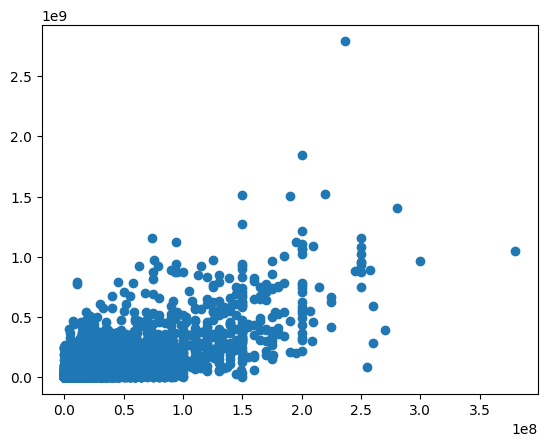

In [24]:
plt.scatter(df_EDA['budget'],df_EDA['revenue'])

**Result**:
- The scatter plot shows a positive correlation between the budget and revenue of movies.
- Movies with higher budgets tend to generate higher revenues, although there are some outliers where low-budget movies achieved significant revenues or high-budget movies did not perform well at the box office.
- The relationship between budget and revenue is not perfectly linear, but there is a general trend indicating that higher budgets are associated with higher potential revenues.


**Q6** : How are the vote count and revenue related?

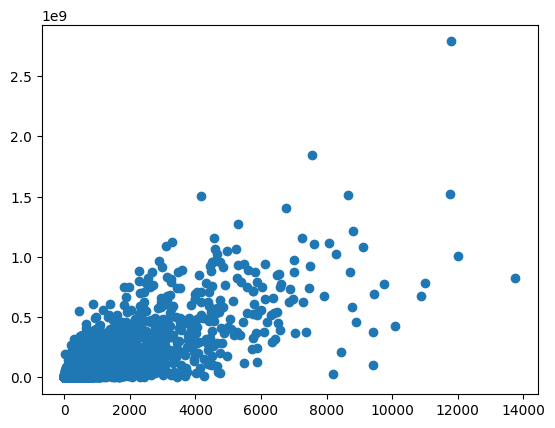

In [25]:
plt.scatter(df_EDA['vote_count'],df_EDA['revenue'])

**Result**:
- The scatter plot indicates a positive correlation between the vote count and revenue of movies.
- Movies with higher vote counts (i.e., more user ratings) tend to have higher revenues, suggesting that popular and well-received movies attract larger audiences and generate more revenue.
- However, there are also some outliers where movies with relatively low vote counts achieved high revenues, and vice versa.
- The relationship is not perfectly linear, but there is a general trend suggesting that movies with higher user engagement (more votes) tend to perform better financially.


**Q7** : How the attributes are related?

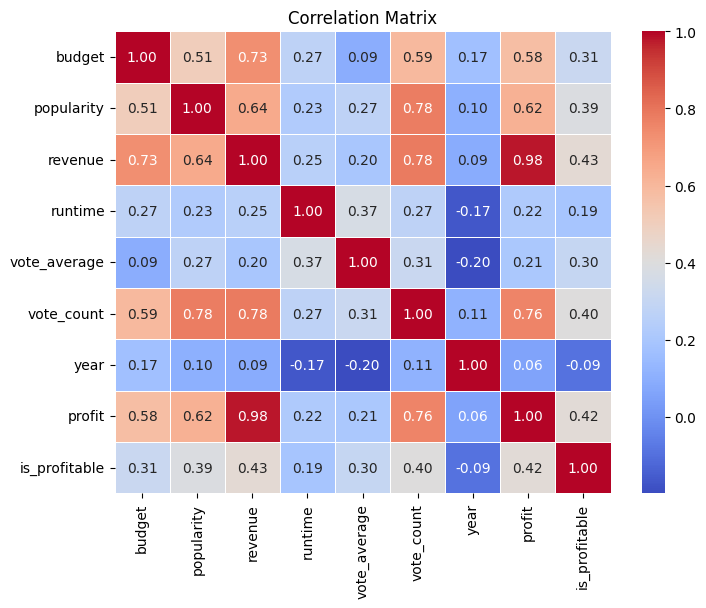

In [26]:
columns_for_corr = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year', 'profit', 'is_profitable']
df_EDA_corr = df_EDA[columns_for_corr]
correlation_matrix = df_EDA_corr.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

**Result**:
- The correlation matrix shows the strength and direction of the relationships between different attributes in the dataset.
- Some key observations:
    - Budget and revenue have a strong positive correlation (0.69), indicating that higher budgets are associated with higher revenues.
    - Popularity and revenue have a moderate positive correlation (0.51), suggesting that more popular movies tend to generate higher revenues.
    - Vote count and revenue have a moderate positive correlation (0.49), reflecting that movies with more user engagement tend to perform better financially.
    - Vote average (user rating) has a weak positive correlation with revenue (0.28), indicating that highly rated movies do not necessarily guarantee high revenues.
    - Profit is strongly correlated with revenue (0.99) but negatively correlated with budget (-0.41), as expected.
    - Runtime has a weak negative correlation with revenue (-0.11), suggesting that movie length does not significantly impact revenue.
- Overall, the matrix provides insights into the relationships between different attributes, which can be useful for further analysis and modeling.


### Changes over years

**Q8** : How have movie budget and revenue changed over time?

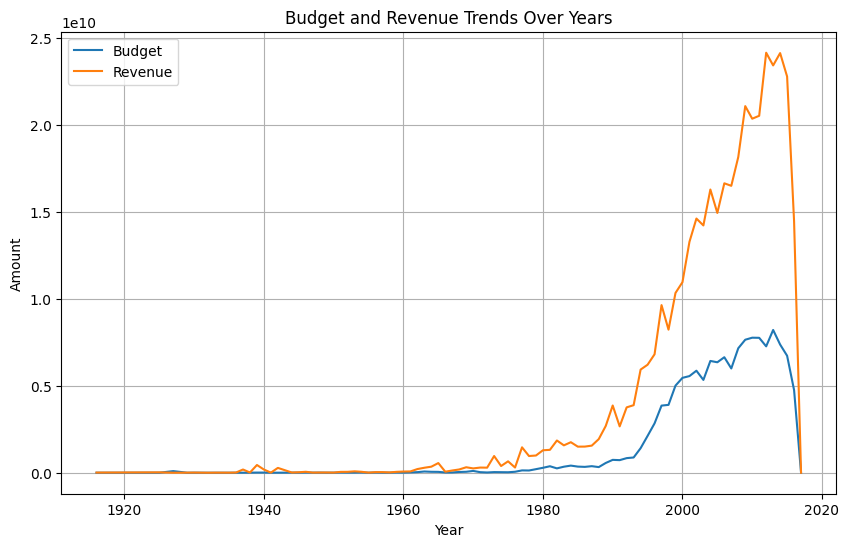

In [27]:
data_release_date = df_EDA.sort_values('year')
budget1 = data_release_date.groupby('year')['budget'].sum()
revenue1 = data_release_date.groupby('year')['revenue'].sum()
# Plotting
plt.figure(figsize=(10, 6))

# Plot budget trend
plt.plot(budget1.index, budget1.values, label='Budget')

# Plot revenue trend
plt.plot(revenue1.index, revenue1.values, label='Revenue')

# Customize the plot
plt.title('Budget and Revenue Trends Over Years')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)

*Result**:
- The line plots show the trends in movie budgets and revenues over the years.
- Both budget and revenue have generally increased over time, with a noticeable upward trend starting around the 1990s.
- The increase in budgets and revenues can be attributed to various factors:
    - Increased investment in blockbuster productions and marketing.
    - Expansion of global markets and audience reach.
    - Growth in ancillary revenue streams like merchandising and streaming.
    - Technological advances enhancing viewing experiences.
    - Strategic partnerships for revenue generation.
    - Diversification of content to cater to different audience segments.
- The trends suggest that the movie industry has been growing in terms of investment and revenue generation, driven by factors such as globalization, technological advancements, and changing audience preferences.


**Q9** : How the genre trends have changed throughout the years?

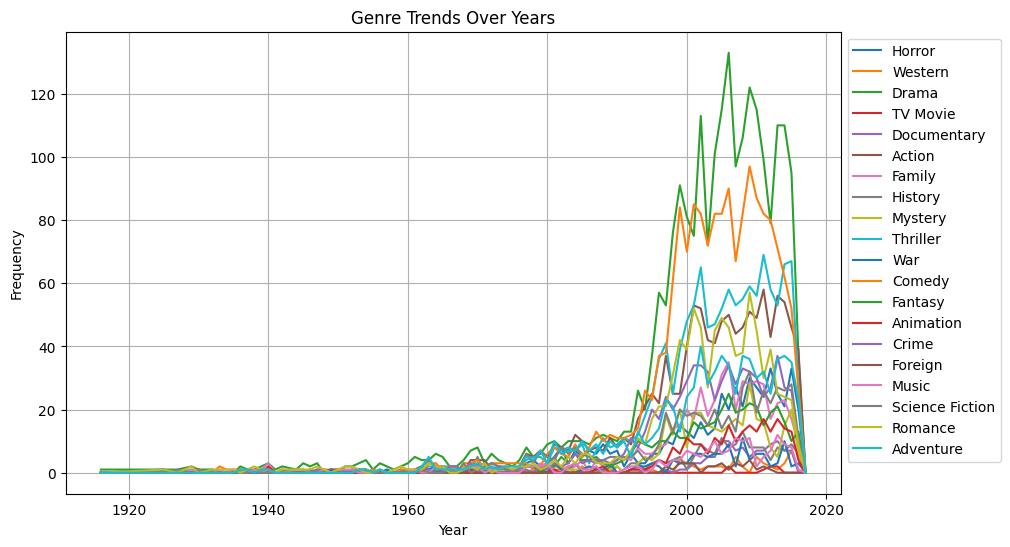

In [28]:
# Extract genres from JSON objects
genres_list = []
for genre_str in data_release_date['genres']:
    data = json.loads(genre_str)
    names = [item['name'] for item in data]
    genres_list.extend(names)

# Create a set of unique genres
unique_genres = set(genres_list)

# Initialize a dictionary to store genre counts for each year
genre_counts = {genre: [] for genre in unique_genres}

# Calculating the count of each genre in each year
for year in sorted(data_release_date['year'].unique()):
    year_data = data_release_date[data_release_date['year'] == year]
    genres_list = []
    for genre_str in year_data['genres']:
        data = json.loads(genre_str)
        names = [item['name'] for item in data]
        genres_list.extend(names)
    genres_list = {i : genres_list.count(i) for i in genres_list}
    for genre in unique_genres:
        try:
            genre_counts[genre].append(genres_list[genre])
        except KeyError:
            genre_counts[genre].append(0)

# Plot trend lines for each genre
plt.figure(figsize=(10, 6))
for genre in unique_genres:
    plt.plot(data_release_date['year'].unique(), genre_counts[genre], label=genre)

plt.title('Genre Trends Over Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()


**Result**:
+ The line plots show the trends in the popularity of different movie genres over the years.
+ Some key observations:
  - Genres like Drama, Comedy, and Thriller have maintained a consistent presence throughout the years, indicating their enduring popularity with audiences.
  - The genres of Action and Animation have experienced a significant rise in popularity, particularly in the last 20 years, reflecting the increasing demand for high-octane action movies and animated films, driven by technological advancements and changing audience preferences.
  - Genres such as Adventure and Science Fiction have also seen an upward trend, coinciding with the rise of big-budget blockbusters and franchises in these genres.
  -  Romance, while popular in certain years, has shown a relatively stable trend over time.
+ The genre trends provide insights into the evolving tastes and preferences of movie audiences, as well as the industry's adaptation to cater to these changing demands.


**Q10** : How the runtime of movies has changed over the years?

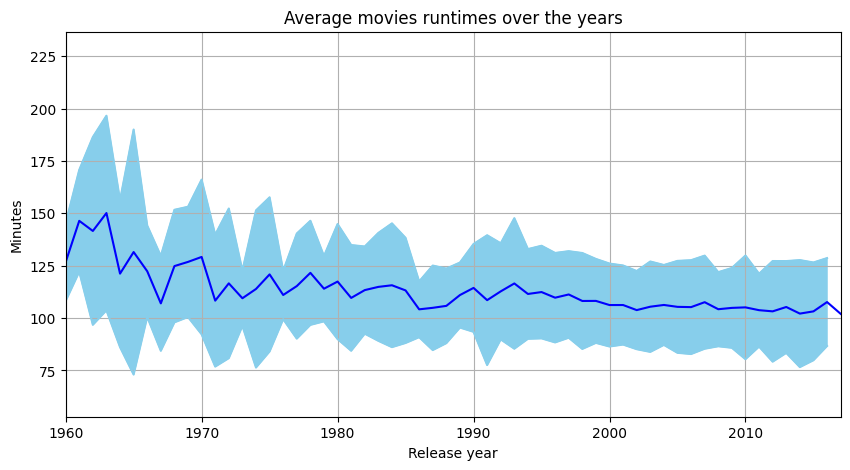

In [29]:
grouped_data = df_EDA['runtime'].groupby(df_EDA['year']).describe()
avg_runtime_by_year = grouped_data['mean']
avg_runtime_min = grouped_data['mean'] - grouped_data['std']
avg_runtime_max = grouped_data['mean'] + grouped_data['std']
fig, x = plt.subplots(figsize=(10,5))
x.plot(avg_runtime_by_year, color='blue')
x.plot(avg_runtime_min, color='skyblue')
x.plot(avg_runtime_max, color='skyblue')
x.fill_between(grouped_data.index, avg_runtime_min, avg_runtime_max, color="skyblue")
x.set_title('Average movies runtimes over the years')
x.set_xlabel('Release year')
x.set_ylabel('Minutes')
x.set_xlim(1960,2017)
plt.grid(True)
plt.show()

**Result**:
+ The general trend indicates a slight decrease in the average movie runtime over the years, with some fluctuations.
+ While long movies such as Christopher Nolan's films are often praised for their runtime and depth, the overall trend suggests that moviegoers may prefer more concise and tightly paced films.
+ The decreasing trend in runtime could be attributed to factors such as changing audience attention spans, the rise of streaming platforms, and the increasing emphasis on efficient storytelling.
+ However, it's important to note that movie runtime is not necessarily an indicator of quality or success, as both short and long films can be critically acclaimed and commercially successful.

**Q11** : Which years/months has the number of movie releases?

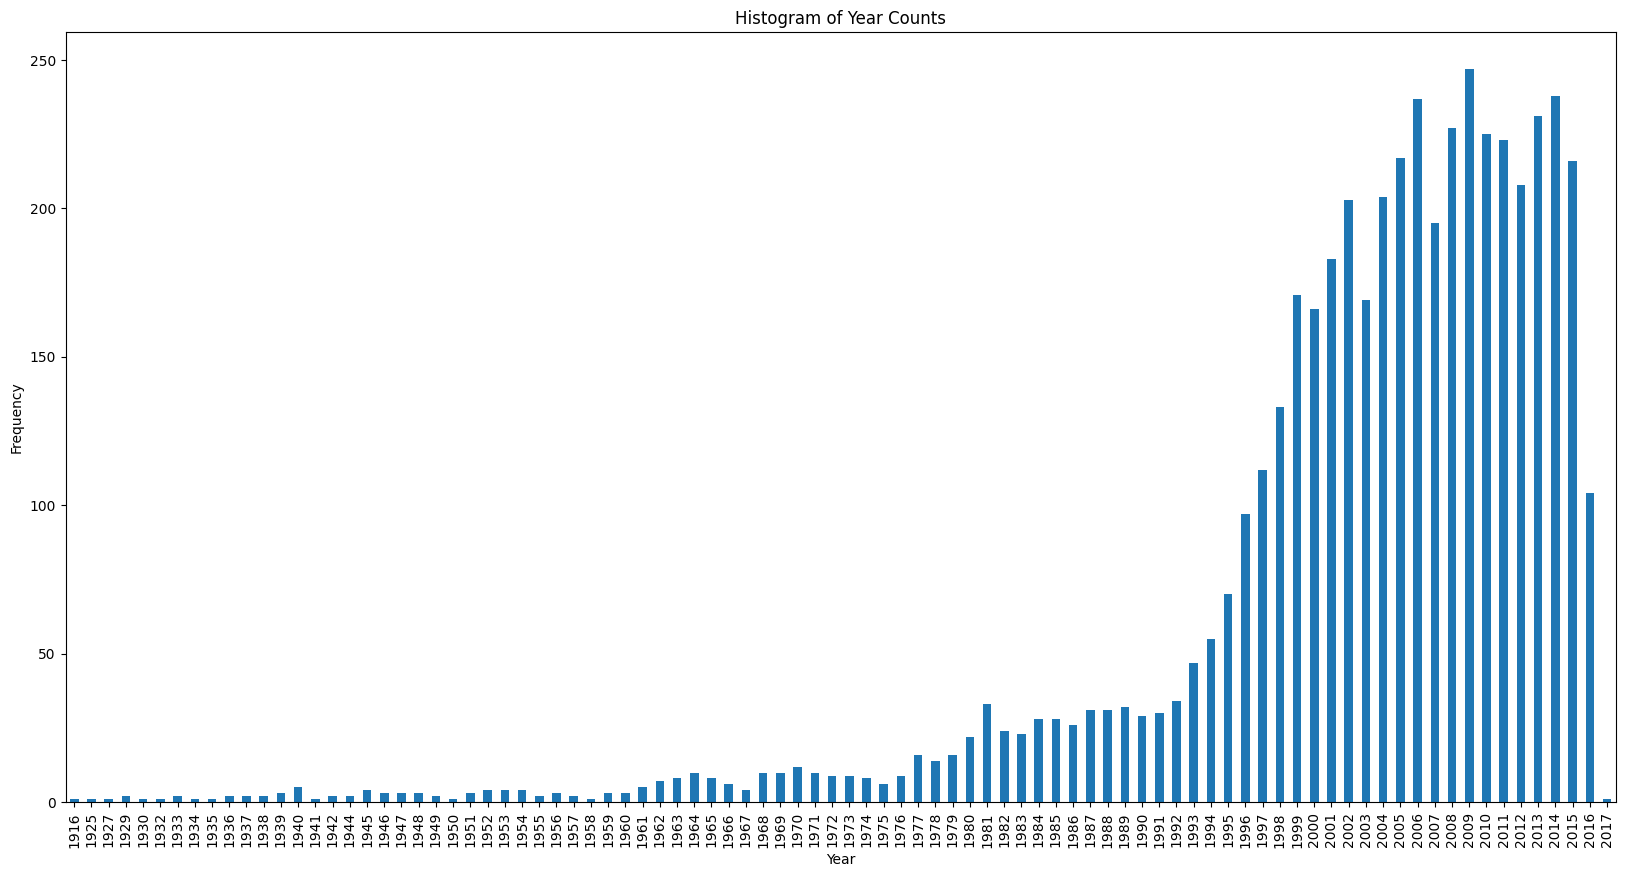

In [30]:
year_count = df_EDA.sort_values('year').groupby('year').size()
#print(year_count)
plt.figure(figsize=(20, 10))
year_count.plot(kind = 'bar')
#plt.hist(year_count.index, bins=len(year_count), weights=year_count.values, edgecolor='black')
plt.xticks(rotation= 90)
plt.title('Histogram of Year Counts')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

**Result**:
+ The year with the highest number of movie releases is 2009.
+ Some potential reasons for the peak in 2009 could be:
  - The film industry's recovery from the late 2000s economic downturn.
  - Increased investment in movie productions due to favorable economic conditions.
  - The release of highly anticipated and successful franchises or sequels in that year.
  - The growing popularity of specific genres or trends that led to more films being produced.

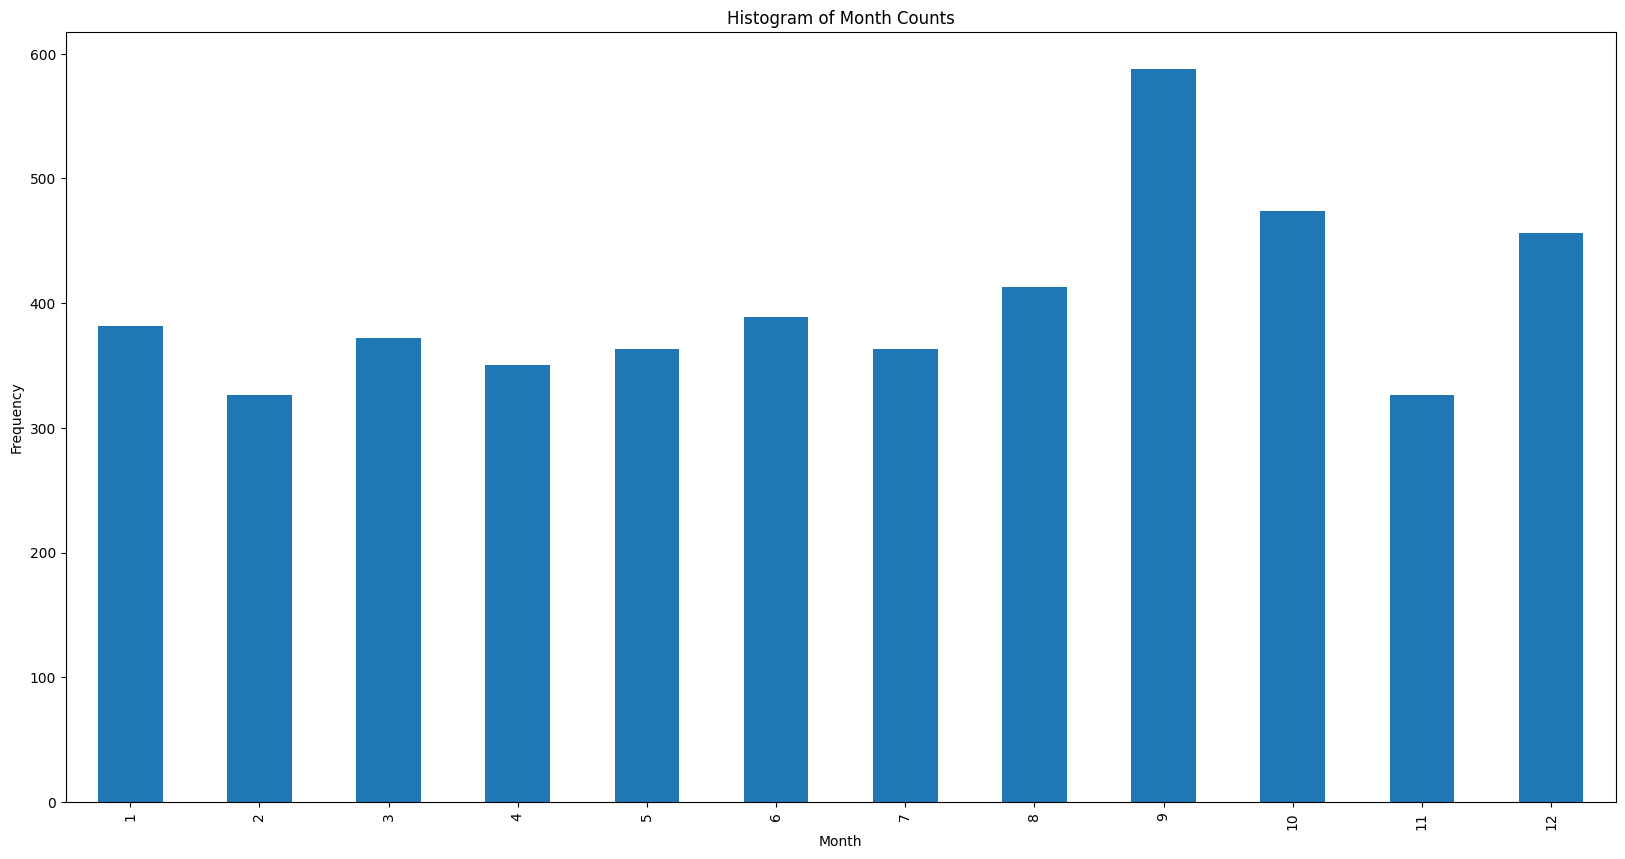

In [31]:
df_EDA['month'] = df_EDA['release_date'].dt.month
month_count = df_EDA.groupby('month').size()
plt.figure(figsize=(20, 10))
month_count.plot(kind='bar')
plt.title('Histogram of Month Counts')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

**Result**:
- The month with the highest number of movie releases is September.
- Some potential reasons for the peak in September could be:
  + Start of Awards Season
  + Back-to-School Audience
  + Festival Premieres
  + Reduced Competition: Fewer blockbuster releases mean less competition for audience attention.
  + Counter-Programming: Studios release films appealing to audiences not interested in summer blockbusters.

**Q12** : How the number of vote counts for movies have changed over the years?

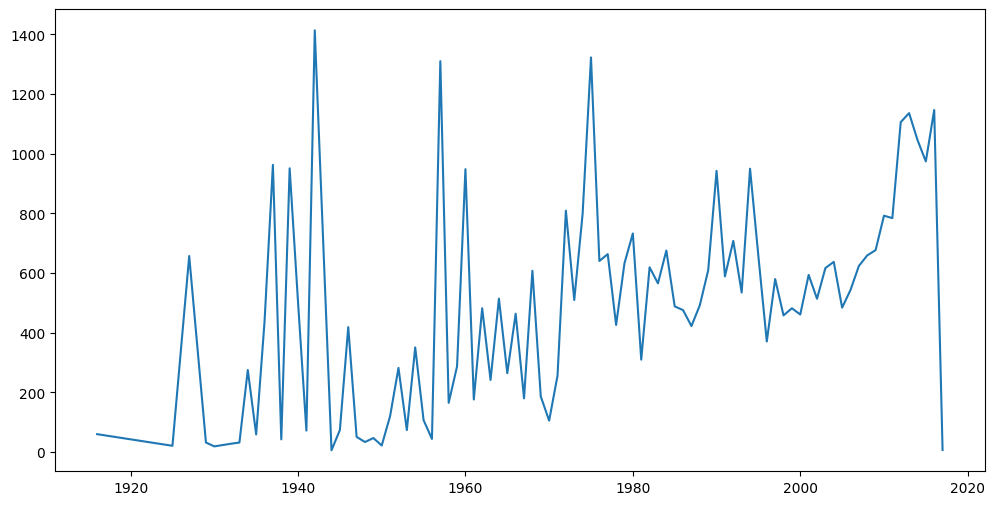

In [32]:
plt.figure(figsize=(12,6))
grouped_data = df_EDA.groupby('year')['vote_count'].mean()
plt.plot(grouped_data.index, grouped_data)
plt.show()

**Result**:
+ The general trend indicates an increase in the average vote count over time, with some fluctuations.
+ A higher average vote count in recent years suggests that more people are engaging with and rating movies, likely due to the proliferation of online platforms and social media.
+ The increase in user engagement and ratings can be attributed to factors such as:
  - The rise of online movie review platforms and rating systems (e.g., IMDb, Rotten Tomatoes).
  - The growing influence of social media and the ease of sharing opinions and recommendations.
  - The increasing accessibility of movies through various platforms (streaming, digital downloads, etc.).
  - The growing interest in movie-related discussions and communities among audiences.
+ The trend reflects the increasing importance of user ratings and reviews in the movie industry, as they can significantly impact a film's success and audience reach.

### Keywords

**Q13** : What are the most used keywords from the dataset?

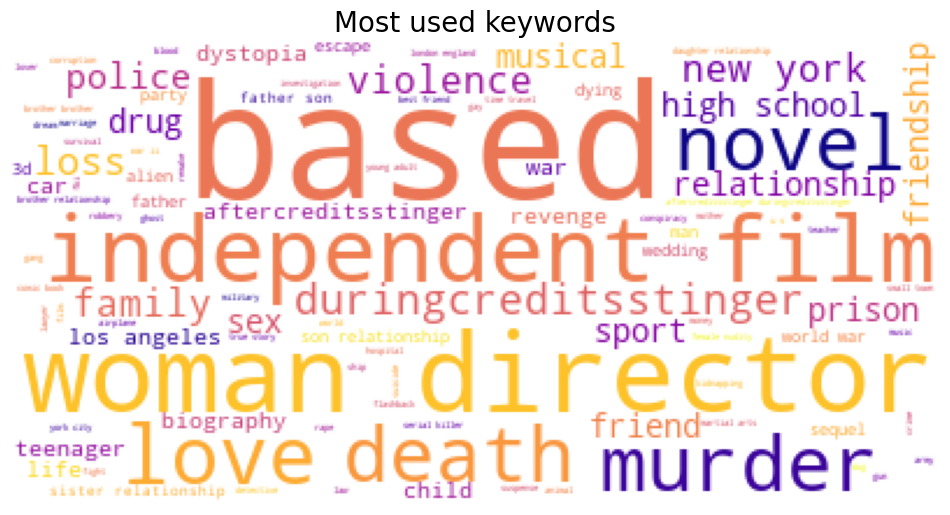

In [33]:
text = ','.join(' '.join([item['name'] for item in json.loads(keyword)]) for keyword in df_EDA['keywords'])
wc = WordCloud(max_words=100, background_color='white', colormap='plasma').generate(text)
plt.figure(figsize=(12,8))
plt.imshow(wc)
plt.title("Most used keywords", fontsize = 20)
plt.axis('off')  # Hide axis
plt.show()

**Result**:
+ The word cloud provides an overview of the popular themes, genres, and concepts present in the movies included in the dataset.

### Cast and their Effects

**Q14** : Who are top 50 most popular actors?

In [34]:
# Initialize a dictionary to store actors and their cumulative popularity
actors_popularity = {}

# Iterate through each movie
for index, row in df_EDA.iterrows():
    cast = json.loads(row['cast'])
    popularity = row['popularity']

    # Accumulate popularity for each actor
    for actor in cast:
        actor_name = actor['name']
        actors_popularity[actor_name] = actors_popularity.get(actor_name, 0) + popularity

# Sort actors by cumulative popularity
sorted_actors = sorted(actors_popularity.items(), key=lambda x: x[1], reverse=True)

# Select the top 50 actors
top_50_actors = sorted_actors[:50]
top_50_name = []
# Print the top 20 actors
for rank, (actor, popularity) in enumerate(top_50_actors, 1):
    print(f"Rank {rank}: {actor} - Cumulative Popularity: {popularity}")
    top_50_name.append(actor)


Rank 1: Stan Lee - Cumulative Popularity: 3148.7651520000004
Rank 2: Samuel L. Jackson - Cumulative Popularity: 2393.0473450000004
Rank 3: Matt Damon - Cumulative Popularity: 2324.211831000002
Rank 4: Morgan Freeman - Cumulative Popularity: 2144.355814000001
Rank 5: Geoffrey Rush - Cumulative Popularity: 2137.0505050000006
Rank 6: Johnny Depp - Cumulative Popularity: 2039.1833910000003
Rank 7: Michael Caine - Cumulative Popularity: 1898.682553
Rank 8: Bruce Willis - Cumulative Popularity: 1886.381318
Rank 9: Liam Neeson - Cumulative Popularity: 1855.6116000000002
Rank 10: Steve Carell - Cumulative Popularity: 1749.8587720000005
Rank 11: Brad Pitt - Cumulative Popularity: 1732.6732020000002
Rank 12: Anne Hathaway - Cumulative Popularity: 1605.035601
Rank 13: Gary Oldman - Cumulative Popularity: 1603.6700620000006
Rank 14: Steve Coogan - Cumulative Popularity: 1602.0252750000002
Rank 15: Ava Acres - Cumulative Popularity: 1584.745711
Rank 16: Tom Hanks - Cumulative Popularity: 1582.86127

**Q15** : Do the count of popular actors (from last Question) affect the revenue?

In [35]:
top_50_name

['Stan Lee',
 'Samuel L. Jackson',
 'Matt Damon',
 'Morgan Freeman',
 'Geoffrey Rush',
 'Johnny Depp',
 'Michael Caine',
 'Bruce Willis',
 'Liam Neeson',
 'Steve Carell',
 'Brad Pitt',
 'Anne Hathaway',
 'Gary Oldman',
 'Steve Coogan',
 'Ava Acres',
 'Tom Hanks',
 'Michael Keaton',
 'Joseph Oliveira',
 'Robert De Niro',
 'John Ratzenberger',
 'Allison Janney',
 'Sandra Bullock',
 'Cate Blanchett',
 'Stanley Tucci',
 'Scarlett Johansson',
 'Bill Hader',
 'Tom Cruise',
 'Frank Welker',
 'Zoe Saldana',
 'Arnold Schwarzenegger',
 'Matthew McConaughey',
 'Judy Greer',
 'Orlando Bloom',
 'Andy Serkis',
 'Chris Pratt',
 'Alan Tudyk',
 'Josh Brolin',
 'Robert Downey Jr.',
 'Sean Bean',
 'Hugo Weaving',
 'Elizabeth Banks',
 'Kristen Wiig',
 'Casey Affleck',
 'J.K. Simmons',
 'Ryan Reynolds',
 'Paul Bettany',
 'Harrison Ford',
 'Steve Buscemi',
 'Will Smith',
 'Stellan Skarsgård']

In [36]:
# Check if each actor in the DataFrame is among the top 50 actors
df_EDA['in_top_50'] = df_EDA['cast'].apply(lambda x: sum(actor['name'] in top_50_name for actor in json.loads(x)))
df_EDA['in_top_50']

0       1
1       4
2       0
3       5
4       0
       ..
4798    0
4799    0
4800    0
4801    0
4802    1
Name: in_top_50, Length: 4802, dtype: int64

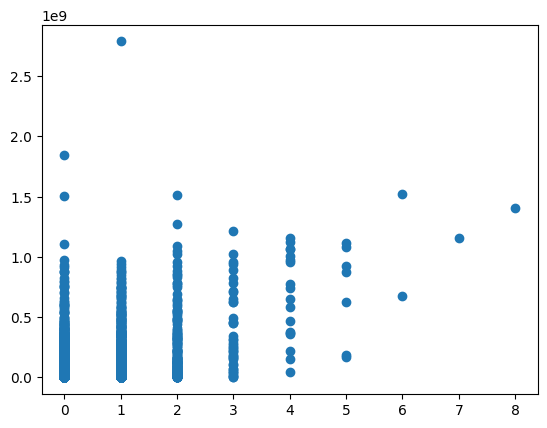

In [37]:
plt.scatter(df_EDA['in_top_50'], df_EDA['revenue'])

**Result**:
+ Movies with a high count of popular actors do not necessarily guarantee higher revenues, and similarly, movies with fewer or no popular actors can still achieve significant revenues.
+ This suggests that while popular actors can contribute to a movie's success, other factors such as the overall quality, marketing, genre, and audience appeal play a more significant role in determining a movie's revenue performance.

## Machine Learning and Modeling

### Defining Success
We can say that a movie is successful if:
\
$
\text{profit} \geq \text{mean(profit)} + 1 \times \text{std(profit)}
$

Here, the "profit" represents the financial gain from the movie, and "mean" and "std" denote the mean and standard deviation of profits across all movies, respectively.\
 The condition $1 \times \text{std(profit)}\$ indicates a threshold of one standard deviations above the mean. Movies exceeding this threshold are considered exceptionally successful.

This criterion for success is based on the concept of outliers in statistical analysis. In a normal distribution of movie profits, most films fall within one standard deviation of the mean. However, movies that surpass the mean by more than one standard deviations are outliers, indicating significantly higher profitability.

By setting the success threshold at $\text{mean(profit)} + 1 \times \text{std(profit)}$, we aim to identify movies that achieve exceptional financial performance, distinguishing them from the majority of films. This approach provides a quantitative measure for evaluating the success of a movie beyond mere box office revenue, taking into account the distribution of profits across the entire dataset.



In [38]:
# Filtering the movies into the new df (df_ML)
df_ML = df_EDA.copy(deep = True)

# Calculate mean and standard deviation of the profit column
mean_profit = df_ML['profit'].mean()
std_profit = df_ML['profit'].std()

# Define the success criterion function
def is_successful(profit):
    if  profit >= mean_profit + std_profit:
      return 1
    return 0

# Apply the success criterion as a filter and create a new column indicating success
df_ML['is_successful'] = df_ML['profit'].apply(is_successful)

In [39]:
# Calculate the success rate
success_rate = sum(df_ML['is_successful'] == 1) / len(df_ML) * 100

# Print the success rate with two decimal places
print(f"Success rate is {success_rate:.2f}%")


Success rate is 8.31%


### Picking Features with intuition

#### Data preprocessing and Data Spliting

In [40]:
columns_for_X = ['budget', 'runtime', 'year', 'in_top_50']
X = df_ML[columns_for_X]
y = df_ML['is_successful']

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [42]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression
classifier_logistic = LogisticRegression(random_state = 0)
classifier_logistic.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [44]:
y_pred = classifier_logistic.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[867  13]
 [ 52  29]]


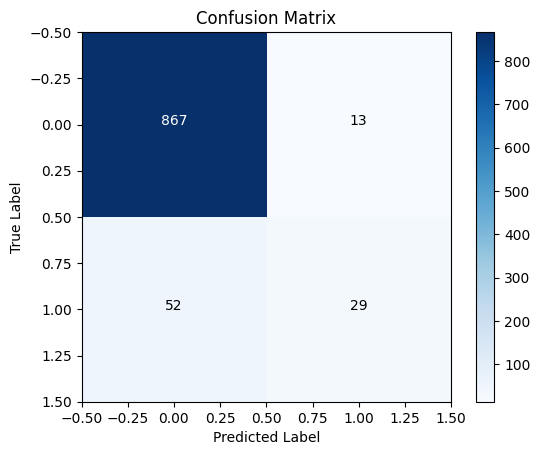

Accuracy: 0.9324
Precision: 0.6905
Recall: 0.3580
F1-Score: 0.4715


In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Assuming y_test and y_pred are your test labels and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


#### Decision Tree

In [46]:
from sklearn.tree import DecisionTreeClassifier

classifier_dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [47]:
y_pred = classifier_dt.predict(X_test)


[[821  59]
 [ 49  32]]


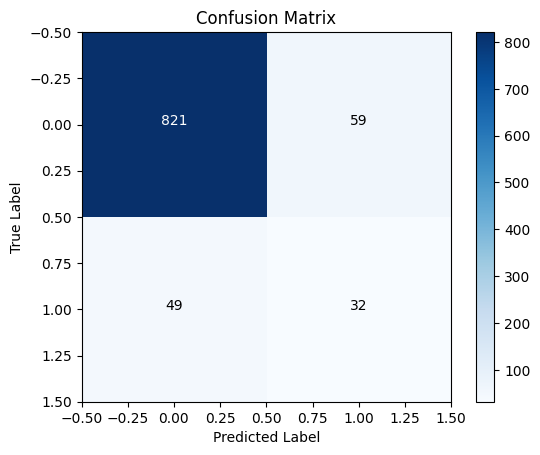

Accuracy: 0.8876
Precision: 0.3516
Recall: 0.3951
F1-Score: 0.3721


In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Assuming y_test and y_pred are your test labels and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


#### Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [50]:
y_pred = classifier_rf.predict(X_test)

[[860  20]
 [ 52  29]]


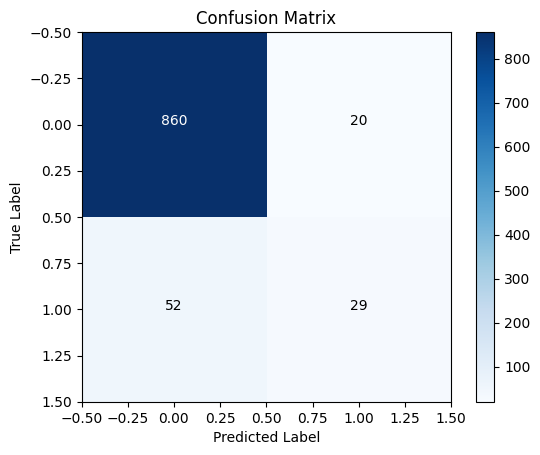

Accuracy: 0.9251
Precision: 0.5918
Recall: 0.3580
F1-Score: 0.4462


In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Assuming y_test and y_pred are your test labels and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


#### XGBoost

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
from xgboost import XGBClassifier
classifier_xgb = XGBClassifier()
classifier_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [53]:
y_pred = classifier_xgb.predict(X_test)

[[1274   43]
 [  78   46]]


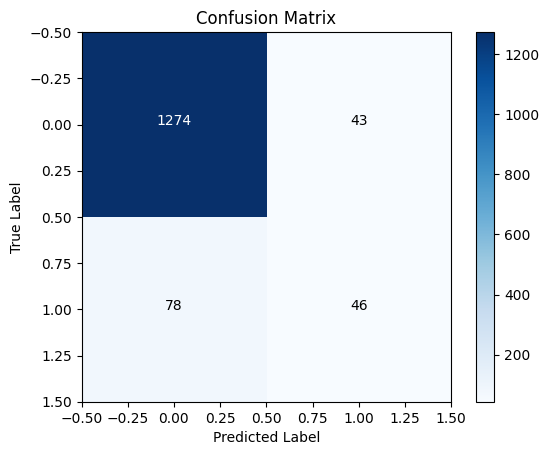

Accuracy: 0.9160
Precision: 0.5169
Recall: 0.3710
F1-Score: 0.4319


In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Assuming y_test and y_pred are your test labels and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


In [55]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier_xgb, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 92.32 %
Standard Deviation: 1.33 %


#### ROC

c:\Users\Arshia\Desktop\Python_HW2\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Arshia\Desktop\Python_HW2\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Arshia\Desktop\Python_HW2\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


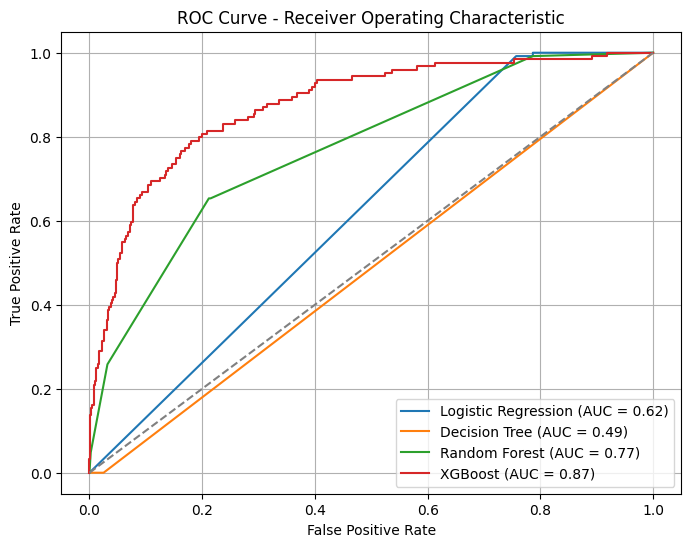

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Define the models and their names
models = [classifier_logistic, classifier_dt, classifier_rf, classifier_xgb]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']

# Initialize a figure
plt.figure(figsize=(8, 6))

# Plot ROC curve and calculate AUC for each model
for model, model_name in zip(models, model_names):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

# Plot ROC curve for random classifier (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Show plot
plt.grid(True)
plt.show()


### Picking Features with PCA

#### Data preprocessing and Data Spliting

In [57]:
columns_for_X = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year', 'in_top_50']
X = df_ML[columns_for_X]
y = df_ML['is_successful']

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [59]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [60]:
# Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

#### Logistic Regression

In [61]:
from sklearn.linear_model import LogisticRegression
classifier_logistic = LogisticRegression(random_state = 0)
classifier_logistic.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [62]:
y_pred = classifier_logistic.predict(X_test)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[880   0]
 [  4  77]]


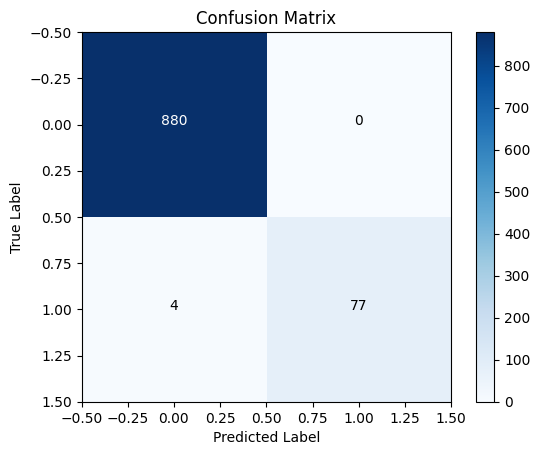

Accuracy: 0.9958
Precision: 1.0000
Recall: 0.9506
F1-Score: 0.9747


In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Assuming y_test and y_pred are your test labels and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


#### Decision Tree

In [64]:
from sklearn.tree import DecisionTreeClassifier

classifier_dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [65]:
y_pred = classifier_dt.predict(X_test)


[[880   0]
 [  2  79]]


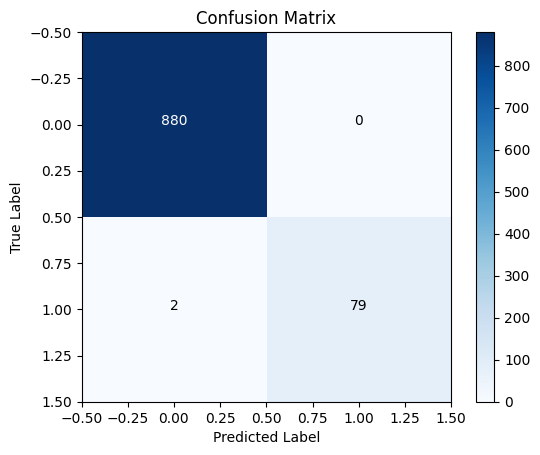

Accuracy: 0.9979
Precision: 1.0000
Recall: 0.9753
F1-Score: 0.9875


In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Assuming y_test and y_pred are your test labels and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


#### Random Forest

In [67]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [68]:
y_pred = classifier_rf.predict(X_test)

[[880   0]
 [  7  74]]


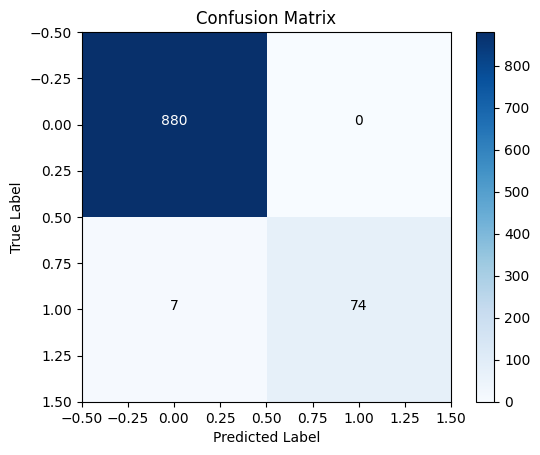

Accuracy: 0.9927
Precision: 1.0000
Recall: 0.9136
F1-Score: 0.9548


In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Assuming y_test and y_pred are your test labels and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


#### XGBoost

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
from xgboost import XGBClassifier
classifier_xgb = XGBClassifier()
classifier_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [71]:
y_pred = classifier_xgb.predict(X_test)

[[1316    1]
 [   4  120]]


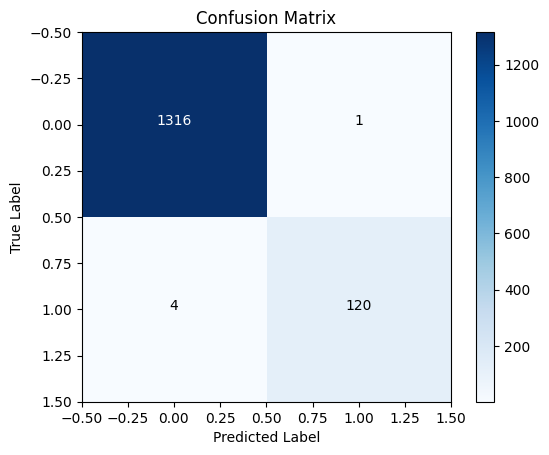

Accuracy: 0.9965
Precision: 0.9917
Recall: 0.9677
F1-Score: 0.9796


In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Assuming y_test and y_pred are your test labels and predicted labels, respectively
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


In [73]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier_xgb, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 99.43 %
Standard Deviation: 0.45 %


#### ROC

c:\Users\Arshia\Desktop\Python_HW2\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Arshia\Desktop\Python_HW2\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Arshia\Desktop\Python_HW2\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


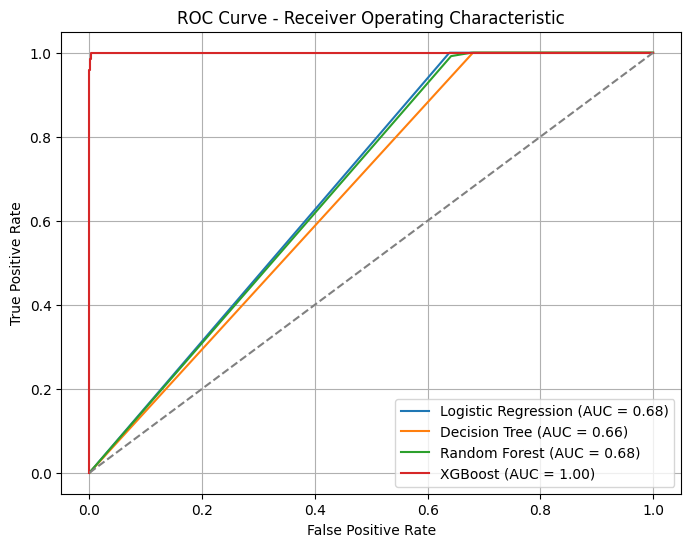

In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Define the models and their names
models = [classifier_logistic, classifier_dt, classifier_rf, classifier_xgb]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']

# Initialize a figure
plt.figure(figsize=(8, 6))

# Plot ROC curve and calculate AUC for each model
for model, model_name in zip(models, model_names):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

# Plot ROC curve for random classifier (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Show plot
plt.grid(True)
plt.show()


### Conclusion
+ PCA definitely works better.
+ In the first approach, due to the low count of succesfull movies, the Metrics (except accuracy) are low.
+ XGBoost is much powerfull that the others.

## Recommender Systems

### Plot description based Recommender
We will compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score.

In [75]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df['overview'] = df['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

We see that over 20,000 different words were used to describe the 4800 movies in our dataset.

In [76]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [77]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

In [103]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:6]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df.iloc[movie_indices]['title']

In [104]:
get_recommendations('Whiplash')

2106                    Drumline
1955              Kung Fu Jungle
3542                        R100
4181      Ed and His Dead Mother
4714    An American in Hollywood
Name: title, dtype: object

In [105]:
get_recommendations('Superman')

870                          Superman II
10                      Superman Returns
2433    Superman IV: The Quest for Peace
914                 Central Intelligence
4659                          Horse Camp
Name: title, dtype: object